# Time stamp based video labeling from single camera

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


### Code reference

#### Code preference: '1649','1648', # ignore '3261','1392'

#### Good visibility: 1646, 1475

### Function to label dataset of videos or images based on labels' timestamps

In [48]:
import numpy as np, pandas as pd

def label_videos(videos, dt_col, label_params, partially_labeled_videos_path=None):

    # create video dataset copy for labeling

    videos_copy = videos.copy()

    for params in label_params:

        # define parameters

        label_series = params['label_series']
        query = params['query'] if 'query' in params else {}

        # take video dataset

        df = videos.copy()

        # format labels' timestamps

        label_series = pd.Series(label_series)
        label_series.index = pd.to_datetime(label_series.index)
        label_series.sort_index(inplace=True)
        stamps = label_series.index
        n_stamps = len(stamps)

        # query video dataset

        for key in query: # accepts either direct value or list
            values = query[key] if type(query[key]) is list else [query[key]]
            df = df[df[key].isin(values)]

        # cut video dataset to enclose provided timestamps

        start, end = stamps.min(), stamps.max()
        df = df[(df[dt_col] >= start) & (df[dt_col] <= end)]

        # generated labels by timestamp interval

        labels = pd.Series(np.nan, index=df.index) # np.nan series with the index of the filtered dataset

        for i in range(n_stamps - 1):
            t1, t2 = stamps[i], stamps[i + 1] # label start and end timestamps
            msk_t = (df[dt_col] >= t1) & (df[dt_col] <= t2)
            labels[msk_t] = label_series.loc[t1]

        # create columns with labels (for the subset and complete datasets)

        df['tag'] = labels
        videos_copy.loc[df.index, 'tag'] = df['tag']

        # save videos partial dataset as csv (completely labeled)
        
        if 'path' in params:
            path = params['path']
            df.to_csv(path, index=False)

        # display label count result

        display(df['tag'].value_counts().to_frame(f'Tag count · code: {query["code"]}'))

    # save videos complete dataset as csv (partially labeled)

    if partially_labeled_videos_path is not None:
        videos_copy.to_csv(partially_labeled_videos_path, index=False)
        
    return videos_copy

### Load videos and images control datasets

In [49]:
import numpy as np, pandas as pd

# load videos dataset

video_control_path = 'Dados/Controle de vídeos/videos_control_2023-04-28.csv'
videos = pd.read_csv(video_control_path)

# load images dataset

image_control_path = 'Dados/Controle de vídeos/images_control_2023-04-28.csv'
images = pd.read_csv(image_control_path)

# data preprocessing
videos['timestamp'] = pd.to_datetime(videos['timestamp'])
images['timestamp'] = pd.to_datetime(images['timestamp'])
images['image_timestamp'] = pd.to_datetime(images['image_timestamp'])

### Define video/image  labels' timestamps and parameters

In [50]:
# path parameters

partially_labeled_videos_path = 'Dados/Rotulados/videos_control_labeled_2023-04-28.csv'
partially_labeled_imags_path = 'Dados/Rotulados/images_control_labeled_2023-04-28.csv'

# label parameters

label_params = [{
    'path': 'Dados/Rotulados/CODE1475_labeled_2023-04-28.csv',
    'query': {
        'code': 1475,
        'folder_structure': [
            '{source}/{type}/{event}/{code}',
            'polygons/{type}/{polygon}/{code}',
        ]
    },
    'label_series': { # timestamps below should enclose the timestamps of all videos matching `query`
        '2023-02-07 19:25:00': 'alagamento', # start 07/02
        '2023-02-08 00:35:00': 'bolsão', # start 08/02
        '2023-02-08 01:20:00': 'lâmina',
        '2023-02-08 01:52:30': 'poça',
        '2023-02-08 02:32:30': 'normalidade',
        '2023-02-11 20:50:00': 'alagamento', # start 11/02
        '2023-02-11 20:51:00': 'normalidade', # end 11/02
        '2023-03-02 00:00:00': 'normalidade', # after end of 2023-03-01 ?
    }
}, {
    'path': 'Dados/Rotulados/CODE1487_labeled_2023-04-28.csv',
    'query': {
        'code': 1487,
        'folder_structure': [
            '{type}/{subtype}/{code}',
            'polygons/{type}/{polygon}/{code}',
        ]
    }, # ****************** RECHECK FOR MISSING HOLES BETWEEN VIDEOS *******************************
    'label_series': { # timestamps below should enclose the timestamps of all videos matching `query`
        '2023-02-07 19:25:00': 0.2, # right before start of 2023-02-07 video
        '2023-02-07 19:49:55': 1.0,
        '2023-02-07 20:09:30': 0.8,
        '2023-02-07 20:10:35': 0.6,
        '2023-02-07 20:11:50': 0.4,
        '2023-02-07 20:14:20': 0.2,
        '2023-02-07 22:35:00': 0.0, # right after end of 2023-02-07 video
        '2023-02-08 01:09:55': 0.0, # right before start of 2023-02-08 video
        '2023-02-08 10:00:00': 0.0, # right after end of 2023-02-08 video
        '2023-02-08 15:50:00': 0.0, # right before start of second 2023-02-08 video
        '2023-02-08 16:25:00': 0.0, # right after end of second 2023-02-08 video
        '2023-04-07 11:35:00': 0.0, # right before start of 2023-04-07 video
        '2023-04-07 20:56:00': 0.0, # right after end of 2023-04-07 video
        '2023-04-07 21:04:00': 0.0, # right before start of second 2023-04-07 video
        '2023-04-07 23:56:00': 0.0, # right after end of second 2023-04-07 video
        '2023-04-08 00:00:00': 0.0, # right before start of 2023-04-08 video
        '2023-04-08 03:19:55': 0.2,
        '2023-04-08 03:39:55': 0.4,
        '2023-04-08 03:44:55': 0.6,
        '2023-04-08 04:14:55': 0.4,
        '2023-04-08 04:24:55': 0.2,
        '2023-04-08 05:14:55': 0.0,
        '2023-04-08 06:14:55': 0.2,
        '2023-04-08 06:39:55': 0.0,
        '2023-04-08 06:49:55': 0.2,
        '2023-04-08 07:14:55': 0.0,
        '2023-04-08 07:59:55': 0.2,
        '2023-04-08 10:14:55': 0.0,
    }
}]

### Label videos from multiple cameras  based on labels' timestamps

In [51]:
control = videos.copy()
dt_col = 'timestamp'
partially_labeled_videos_path = 'Dados/Rotulados/videos_control_labeled_2023-04-28.csv'

videos_labeled = label_videos(control, dt_col, label_params, partially_labeled_videos_path)

,Tag count · code: 1475
normalidade,120
alagamento,28
poça,8
lâmina,5
bolsão,4


,Tag count · code: 1487
0.0,276
0.2,70
0.6,6
1.0,5
0.4,3


### Label images from multiple cameras based on labels' timestamps

In [52]:
control = images.copy()
dt_col = 'image_timestamp'
partially_labeled_images_path = 'Dados/Rotulados/images_control_labeled_2023-04-28.csv'

images_labeled = label_videos(control, dt_col, label_params, partially_labeled_images_path)

,Tag count · code: 1475
normalidade,884
alagamento,14


,Tag count · code: 1487
0.0,7294
0.2,1938
0.6,270
0.4,135


#### Evaluate results

In [55]:
t1 = '2023-02-07 19:49:55'
t2 = '2023-02-07 20:09:30'

t1, t2 = (pd.datetime.strptime(ti, '%Y-%m-%d %H:%M:%S') for ti in (t1, t2))

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9964\362646071.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  t1, t2 = (pd.datetime.strptime(ti, '%Y-%m-%d %H:%M:%S') for ti in (t1, t2))


In [56]:
col = images_labeled['image_timestamp'] 

msk_t = (col >= t1) & (col <= t2)

images_labeled[msk_t]

,blob_name,blob_size,bucket_name,file_name,code,n_folders,timestamp,folder_structure,image_timestamp,tag


In [57]:
col = images['timestamp'] 

msk_t = (col >= t1) & (col <= t2)

images[msk_t]

,blob_name,blob_size,bucket_name,file_name,code,n_folders,timestamp,folder_structure,image_timestamp


In [58]:
col = videos['timestamp'] 

msk_t = (col >= t1) & (col <= t2)

videos[msk_t]

,blob_name,blob_size,bucket_name,file_name,code,n_folders,timestamp,folder_structure
5897,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,224984,flood-video-collection,CODE1487 2023-02-07 19:50:00.mp4,1487,4,2023-02-07 19:50:00,polygons/{type}/{polygon}/{code}
5898,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,511216,flood-video-collection,CODE1487 2023-02-07 19:54:00.mp4,1487,4,2023-02-07 19:54:00,polygons/{type}/{polygon}/{code}
5899,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,529560,flood-video-collection,CODE1487 2023-02-07 20:00:00.mp4,1487,4,2023-02-07 20:00:00,polygons/{type}/{polygon}/{code}
5900,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,553493,flood-video-collection,CODE1487 2023-02-07 20:03:00.mp4,1487,4,2023-02-07 20:03:00,polygons/{type}/{polygon}/{code}
5901,polygons/flood-unlabeled/-1/1487/CODE1487 2023...,31005571,flood-video-collection,CODE1487 2023-02-07 20:08:37.mp4,1487,4,2023-02-07 20:08:37,polygons/{type}/{polygon}/{code}
...,...,...,...,...,...,...,...,...
14706,polygons/flood-unlabeled/8/120/CODE120 2023-02...,37633,flood-video-collection,CODE120 2023-02-07 20:00:00.mp4,120,4,2023-02-07 20:00:00,polygons/{type}/{polygon}/{code}
14707,polygons/flood-unlabeled/8/120/CODE120 2023-02...,38438,flood-video-collection,CODE120 2023-02-07 20:03:00.mp4,120,4,2023-02-07 20:03:00,polygons/{type}/{polygon}/{code}
14708,polygons/flood-unlabeled/8/120/CODE120 2023-02...,43078365,flood-video-collection,CODE120 2023-02-07 20:08:37.mp4,120,4,2023-02-07 20:08:37,polygons/{type}/{polygon}/{code}
14829,polygons/flood-unlabeled/8/267/CODE267 2023-02...,184358,flood-video-collection,CODE267 2023-02-07 19:50:00.mp4,267,4,2023-02-07 19:50:00,polygons/{type}/{polygon}/{code}


---
## Exploratory data analysis 

In [3]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


In [ ]:
import numpy as np, pandas as pd

### Analysis of labeled videos and images

#### Reload videos and image labeled datasets

In [17]:
videos = pd.read_csv('Dados/Rotulados/videos_control_labeled_2023-04-28.csv')
images = pd.read_csv('Dados/Rotulados/images_control_labeled_2023-04-28.csv')

# datetime conversion
videos['timestamp'] = pd.to_datetime(videos['timestamp'])
images['timestamp'] = pd.to_datetime(images['timestamp'])
images['image_timestamp'] = pd.to_datetime(images['image_timestamp'])

# set datetime index
videos = videos.set_index('timestamp', drop=True).sort_index()

images.head()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_6076\1057483232.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  images = pd.read_csv('Dados/Rotulados/images_control_labeled_2023-04-28.csv')


,blob_name,blob_size,bucket_name,file_name,code,n_folders,timestamp,folder_structure,image_timestamp,tag
0,comando/alagamento/93898/1993/CODE1993 2023-03...,1317301,flood-video-collection,CODE1993 2023-03-30 19-55-06.mp4,1993,4,2023-03-30 19:55:06,{source}/{type}/{event}/{code},2023-03-30 19:55:06.000,NaN
1,comando/alagamento/93898/1993/CODE1993 2023-03...,1317301,flood-video-collection,CODE1993 2023-03-30 19-55-06.mp4,1993,4,2023-03-30 19:55:06,{source}/{type}/{event}/{code},2023-03-30 19:55:06.333,NaN
2,comando/alagamento/93898/1993/CODE1993 2023-03...,1317301,flood-video-collection,CODE1993 2023-03-30 19-55-06.mp4,1993,4,2023-03-30 19:55:06,{source}/{type}/{event}/{code},2023-03-30 19:55:06.667,NaN
3,comando/alagamento/93898/1993/CODE1993 2023-03...,1317301,flood-video-collection,CODE1993 2023-03-30 19-55-06.mp4,1993,4,2023-03-30 19:55:06,{source}/{type}/{event}/{code},2023-03-30 19:55:07.000,NaN
4,comando/alagamento/93898/1993/CODE1993 2023-03...,1317301,flood-video-collection,CODE1993 2023-03-30 19-55-06.mp4,1993,4,2023-03-30 19:55:06,{source}/{type}/{event}/{code},2023-03-30 19:55:07.333,NaN


### Analysis by camera

#### Reload labeled dataset by camera code

In [ ]:
videos = pd.read_csv('Dados/Rotulos/1475_2023-02-07.csv')

videos['timestamp'] = pd.to_datetime(videos['timestamp'])
videos = videos.set_index('timestamp', drop=True).sort_index()

videos.head()

#### Bytes of largest videos

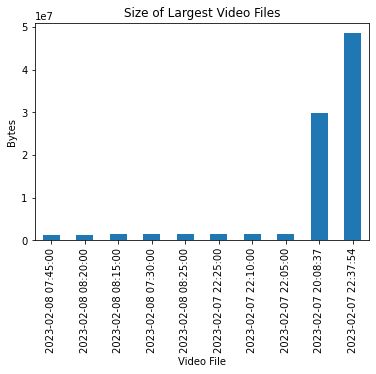

In [6]:
ax = videos['blob_size'].sort_values(ascending=True).tail(10).plot.bar(
    ylabel='Bytes', xlabel='Video File', title='Size of Largest Video Files'
)